Plot synthesized dataset (Trajectron++ data).
Produce counts of recorded vehicle positions in the dataset,
and count incidences when recorded vehicle is in a junction or making a turn. 

In [1]:
%matplotlib inline

import collections
import math
import os
import sys
import json
from glob import glob
from timeit import default_timer as timer

from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import dill
import scipy.ndimage
import shapely
import shapely.geometry
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.patheffects as pe
import cv2 as cv

PYTHONAPI_EGG_PATH = f"{ os.environ['HOME'] }/src/carla/PythonAPI/carla/dist/carla-0.9.11-py3.7-linux-x86_64.egg"
sys.path.append('../Trajectron-plus-plus/trajectron')
sys.path.append('../Trajectron-plus-plus/experiments/nuScenes')
sys.path.append('..')
sys.path.append(PYTHONAPI_EGG_PATH)

import carla
import utility as util
import carlautil
from helper import *
import visualization
from model.dataset import *
from model.components import *
from model.model_utils import *

AGENT_COLORS = [
        'blue', 'darkviolet', 'dodgerblue', 'darkturquoise',
        'green', 'gold', 'orange', 'red', 'deeppink']
AGENT_COLORS = np.array(AGENT_COLORS) \
        .take([(i * 5) % len(AGENT_COLORS) for i in range(17)], 0)
NCOLORS = len(AGENT_COLORS)

CARLA_HOST = '127.0.0.1'
CARLA_PORT = 2000

Trajectron helpers

In [2]:
def get_ego_node(nodes):
    nodes = filter(lambda k: 'VEHICLE/ego' in repr(k), nodes)
    return next(nodes)

def get_scene(s):
    sel_scenes = list(filter(lambda scene : scene.name in [s], eval_scenes))
    print(sel_scenes)
    scene = sel_scenes[0]
    return scene

def node_to_df(node):
    columns = ['_'.join(t) for t in node.data.header]
    return pd.DataFrame(node.data.data, columns=columns)

def scene_to_df(scene):
    dfs = [node_to_df(node) for node in scene.nodes if repr(node.type) == 'VEHICLE']
    tmp_dfs = []
    for node, df in zip(scene.nodes, dfs):
        df.insert(0, 'node_id', str(node.id))
        df.insert(0, 'frame_id', range(len(df)))
        tmp_dfs.append(df)
    return pd.concat(tmp_dfs)

def scenes_to_df(scenes):
    dfs = []
    for scene in scenes:
        df = scene_to_df(scene)
        # df.loc[df['node_id'] == 'ego','node_id'] = agent_id
        df['node_id'] = scene.name + '/' + df['node_id']
        df[['position_x', 'position_y']] += np.array([scene.x_min, scene.y_min])
        dfs.append(df)
    return pd.concat(dfs)

Search datasets

In [3]:
search_datasets = False
dataset_dir = '..'
glob(f"{ dataset_dir }/*/*.pkl") if search_datasets else []

[]

Load dataset

In [4]:
dataset_1 = util.AttrDict(
        path=f"{ dataset_dir }/carla_v3_0_1_dataset/carla_train_v3_0_1_full.pkl",
        name='carla_train_v3_0_1',
        desc="CARLA synthesized dataset smaller sized with heading fix",
        has_augments=True,
        v2_bitmap=True)

dataset_2 = util.AttrDict(
        path=f"{ dataset_dir }/carla_v3-1_dataset/v3-1_split1_train.pkl",
        name='v3-1',
        desc="CARLA synthesized dataset smaller sized with heading and occlusion fix",
        has_augments=True)

dataset_3 = util.AttrDict(
        path=f"{ dataset_dir }/carla_v3-1-1_dataset/v3-1-1_split1_train.pkl",
        name='v3-1-1',
        desc="CARLA synthesized dataset smaller sized with heading and occlusion fix",
        has_augments=True)

dataset = dataset_3
with open(dataset.path, 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes
print(f"Dataset {dataset.name} contains {len(eval_scenes)} scenes.")

Dataset v3-1-1 contains 200 scenes.


Extract road polygons

In [5]:
def lateral_shift(transform, shift):
    transform.rotation.yaw += 90
    return transform.location + shift * transform.get_forward_vector()

def is_yellow_line(carla_map, waypoint, shift):
    w = carla_map.get_waypoint(lateral_shift(waypoint.transform, shift), project_to_road=False)
    if w is None:
        return False
    return w.lane_id * waypoint.lane_id < 0
    
def extract_road_polygons_from_client(carla_map):
    road_polygons = []
    white_lines   = []
    yellow_lines  = []
    topology      = [x[0] for x in carla_map.get_topology()]
    topology      = sorted(topology, key=lambda w: w.transform.location.z)
    precision     = 0.05
    for waypoint in topology:
        waypoints = [waypoint]
        nxt = waypoint.next(precision)[0]
        while nxt.road_id == waypoint.road_id:
            waypoints.append(nxt)
            nxt = nxt.next(precision)[0]

        left_marking  = carlautil.locations_to_ndarray(
                [lateral_shift(w.transform, -w.lane_width * 0.5) for w in waypoints], flip_y=True)
        right_marking = carlautil.locations_to_ndarray(
                [lateral_shift(w.transform, w.lane_width * 0.5) for w in waypoints], flip_y=True)
        road_polygon = np.concatenate((left_marking, np.flipud(right_marking)), axis=0)

        if len(road_polygon) > 2:
            road_polygons.append(road_polygon)
            if not waypoint.is_intersection:
                sample = waypoints[int(len(waypoints) / 2)]
                if is_yellow_line(carla_map, sample, -sample.lane_width * 1.1):
                    yellow_lines.append(left_marking)
                else:
                    white_lines.append(left_marking)
                if is_yellow_line(carla_map, sample, sample.lane_width * 1.1):
                    yellow_lines.append(right_marking)
                else:
                    white_lines.append(right_marking)
    return road_polygons, white_lines, yellow_lines

# roadpath = 'road_polygons.Town03.pkl'
roadpath = '../cache/map_data.Town03.pkl'
should_extract_from_client = False
if should_extract_from_client:
    map_name = 'Town03'
    client = carla.Client(CARLA_HOST, CARLA_PORT)
    client.set_timeout(10.0)
    world = client.get_world()
    # world = client.load_world(map_name)
    carla_map = world.get_map()
    traffic_manager = client.get_trafficmanager(8000)
    carla_topology = carla_map.get_topology()
    # spawn_points = carla_map.get_spawn_points()
    
    carla_topology = carla_map.get_topology()
    junctions = carlautil.get_junctions_from_topology_graph(carla_topology)
    _junctions = []
    for junction in junctions:
        jx, jy, _ = carlautil.to_location_ndarray(junction, flip_y=True)
        wps = junction.get_waypoints(carla.LaneType.Driving)
        _wps = []
        for wp1, wp2 in wps:
            # wp1 is the waypoint entering into the intersection
            # wp2 is the waypoint exiting out of the intersection
            x, y, _ = carlautil.to_location_ndarray(wp1, flip_y=True)
            _, yaw, _ = carlautil.to_rotation_ndarray(wp1, flip_y=True)
            _wp1 = (x, y, yaw, wp1.lane_width)
            x, y, _ = carlautil.to_location_ndarray(wp2, flip_y=True)
            _, yaw, _ = carlautil.to_rotation_ndarray(wp2, flip_y=True)
            _wp2 = (x, y, yaw, wp2.lane_width)
            _wps.append((_wp1, _wp2))
        _junctions.append({'pos': np.array([jx, jy]), 'waypoints': np.array(_wps)})
    
    ## getting topology waypoints
    # f = lambda wp1, wp2: (
    #         carlautil.to_location_ndarray(wp1, flip_y=True),
    #         carlautil.to_location_ndarray(wp2, flip_y=True))
    # topology = util.map_to_list(lambda wps: f(*wps), carla_topology)

    road_polygons, white_lines, yellow_lines = extract_road_polygons_from_client(carla_map)
    payload = {'road_polygons': road_polygons,
               'white_lines': white_lines,
               'yellow_lines': yellow_lines,
               'junctions': _junctions}
    with open(roadpath, 'wb') as f:
        dill.dump(payload, f, protocol=dill.HIGHEST_PROTOCOL)

with open(roadpath, 'rb') as f:
    payload = dill.load(f, encoding='latin1')
road_polygons = payload['road_polygons']
white_lines   = payload['white_lines']
yellow_lines  = payload['yellow_lines']
junctions  = payload['junctions']

Helper functions for map rendering and getting road bounding boxes.

In [6]:
def render_entire_map(ax):
    for poly in road_polygons:
        patch = patches.Polygon(poly[:, :2], fill=True, color='grey')
        ax.add_patch(patch)
    for line in yellow_lines:
        ax.plot(line.T[0], line.T[1], c='yellow', linewidth=2)
    for line in white_lines:
        ax.plot(line.T[0], line.T[1], c='white', linewidth=2)

def render_map(ax, extent, pixels_per_m=3):
    """Render crop of a map from road polygons defined by extent
    
    Parameters
    ==========
    ax : matplotlib.pyplot.Axes
        The axes to render onto
    extent : tuple of int
        The extent of the map to render of form (x_min, x_max, y_min, y_max) in meters
    pixels_per_m : int
        The number of pixels per meter.
    """
    x_min, x_max, y_min, y_max = extent
    x_size = x_max - x_min
    y_size = y_max - y_min
    dim = (int(pixels_per_m * y_size), int(pixels_per_m * x_size), 3)
    image = np.zeros(dim)

    for polygon in road_polygons:
        rzpoly = ( pixels_per_m*(polygon[:,:2] - np.array([x_min, y_min])) ).astype(int).reshape((-1,1,2))
        cv.fillPoly(image, [rzpoly], (150,150,150))

    for line in white_lines:
        rzline = ( pixels_per_m*(line[:,:2] - np.array([x_min, y_min])) ).astype(int).reshape((-1,1,2))
        cv.polylines(image, [rzline], False, (255,255,255), thickness=2)

    for line in yellow_lines:
        rzline = ( pixels_per_m*(line[:,:2] - np.array([x_min, y_min])) ).astype(int).reshape((-1,1,2))
        cv.polylines(image, [rzline], False, (255,255,0), thickness=2)

    image = image.astype(np.uint8).swapaxes(0,1)
    ax.imshow(image.swapaxes(0,1), extent=extent, origin='lower', interpolation='none')

def render_roads(ax, scene, is_white=False):
    road_color = 'white' if is_white else 'grey'
    map_mask = scene.map['VEHICLE'].as_image()
    # map_mask has shape (y, x, c)
    road_bitmap = np.max(map_mask, axis=2)
    road_div_bitmap = map_mask[..., 1]
    lane_div_bitmap = map_mask[..., 0]

    # extent = (scene.x_min, scene.x_max, scene.y_min, scene.y_max)
    extent = (0, scene.x_size, 0, scene.y_size)

    """
    NuScenes bitmap format
    scene.map[...].as_image() has shape (y, x, c)
    Channel 1: lane, road_segment, drivable_area
    Channel 2: road_divider
    Channel 3: lane_divider
    """
    # NuScenes
    road_bitmap = np.max(map_mask, axis=2)
    road_bitmap = map_mask[..., 0]
    road_div_bitmap = map_mask[..., 1]
    lane_div_bitmap = map_mask[..., 2]
    ax.imshow(road_bitmap,     extent=extent, origin='lower', cmap=colors.ListedColormap(['none', road_color]))
    ax.imshow(road_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'yellow']))
    ax.imshow(lane_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'silver']))

Plot all the junctions and entrance/exits to/from the junctions

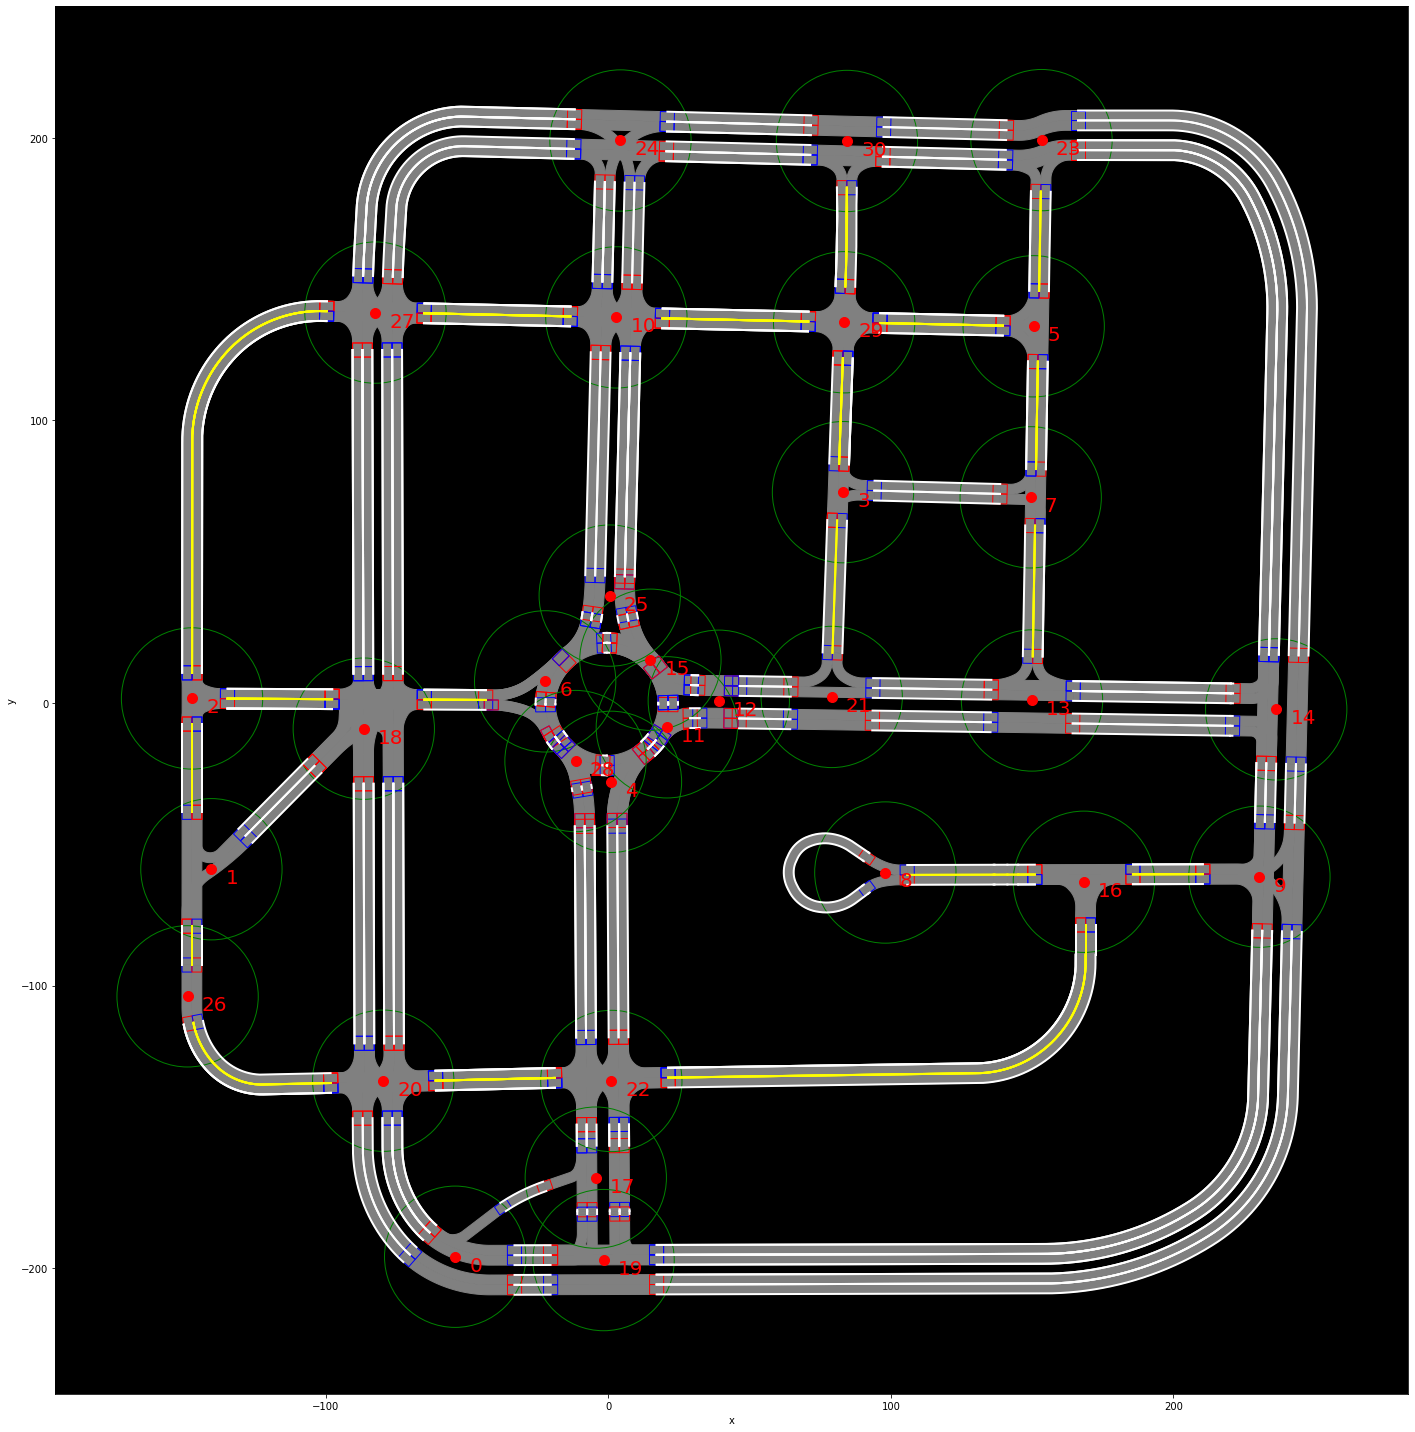

In [7]:
# Plot all the junctions and entrance/exits to/from the junctions
fig, ax = plt.subplots(figsize=(20,20))
render_entire_map(ax)

for idx, junction in enumerate(junctions):
    x, y = junction['pos']
    ax.plot(x, y, 'ro', markersize=10)
    ax.text(x + 5, y - 5, str(idx), color='r', size=20)
    circ = patches.Circle((x, y,), radius=25, color='g', fc='none')
    ax.add_patch(circ)
    for _wp1, _wp2 in junction['waypoints']:
        # entrances are in blue
        x, y, yaw, lane_width = _wp1
        lw = np.array([5.0, lane_width])
        bbox = util.vertices_from_bbox(np.array([x, y]), yaw, lw)
        bb = patches.Polygon(bbox, closed=True, color='b', fc='none')
        ax.add_patch(bb)
        # exits are in red
        x, y, yaw, lane_width = _wp2
        lw = np.array([5.0, lane_width])
        bbox = util.vertices_from_bbox(np.array([x, y]), yaw, lw)
        bb = patches.Polygon(bbox, closed=True, color='r', fc='none')
        ax.add_patch(bb)
        

## when inspecting carla.Junction objects directoy
# for junction in junctions:
#     x, y, _ = carlautil.to_location_ndarray(junction, flip_y=True)
#     ax.plot(x, y, 'ro', markersize=10)
#     wps = junction.get_waypoints(carla.LaneType.Driving)
#     for wp1, _ in wps:
#         lw = np.array([2.0, wp1.lane_width])
#         _, yaw, _ = carlautil.to_rotation_ndarray(wp1, flip_y=True)
#         x, y, _ = carlautil.to_location_ndarray(wp1, flip_y=True)
        
#         bbox = util.vertices_from_bbox(np.array([x, y]), yaw, lw)
#         bb = patches.Polygon(bbox, closed=True, color='b', fc='none')
#         ax.add_patch(bb)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_facecolor('black')
fig.tight_layout()

Plot one scene

In [8]:
scene = eval_scenes[0]
scene_df = scene_to_df(scene)

20 nodes in scene: 103 ego 203 202 197 182 177 145 187 138 129 123 121 115 114 139 164 90 186 192


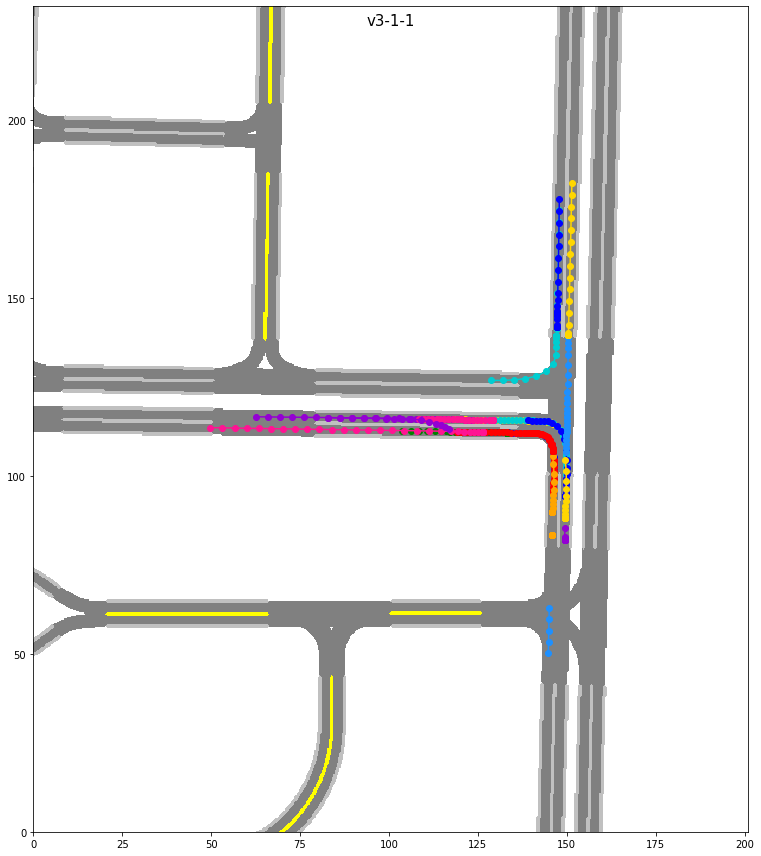

In [9]:
fig, ax = plt.subplots(figsize=(12,12))
render_roads(ax, scene)
scene_df = scene_to_df(scene)
node_ids = scene_df['node_id'].unique()
print(f"{len(node_ids)} nodes in scene: " + ' '.join(node_ids))

for idx, node_id in enumerate(node_ids):
    node_df = scene_df[scene_df['node_id'] == node_id]
    X = node_df[['position_x', 'position_y']].values.T
    ax.plot(X[0], X[1], '-o', color=AGENT_COLORS[idx % NCOLORS])

ax.set_xlim([0, scene.x_size])
ax.set_ylim([0, scene.y_size])
fig.tight_layout()
fig.suptitle(dataset.name, fontsize=15)
None

Export dataset as data frame and get trajectories as line segments

In [10]:
scenes_df = scenes_to_df(eval_scenes)
scenes_df

,frame_id,node_id,position_x,position_y,velocity_x,velocity_y,acceleration_x,acceleration_y,heading_x,heading_y,heading_°,heading_d°,velocity_norm,acceleration_norm
0,0,Town03/ep000/agent089/frame00007183/103,212.453674,-9.680142,2.409210,-0.026939,-0.080048,-0.000051,0.999943,-0.010707,-0.010707,-0.000588,2.409361,0.080048
1,1,Town03/ep000/agent089/frame00007183/103,213.658279,-9.693612,2.369186,-0.026965,-0.066193,-0.000706,0.999939,-0.011001,-0.011001,-0.000649,2.369340,0.066196
2,2,Town03/ep000/agent089/frame00007183/103,214.822861,-9.707108,2.343018,-0.027645,-0.014694,-0.001886,0.999936,-0.011356,-0.011356,-0.000748,2.343181,0.014815
3,3,Town03/ep000/agent089/frame00007183/103,216.001297,-9.721257,2.354492,-0.028852,0.016068,-0.002454,0.999931,-0.011749,-0.011749,-0.000848,2.354669,0.016254
4,4,Town03/ep000/agent089/frame00007183/103,217.177353,-9.735959,2.359085,-0.030099,0.010986,-0.002501,0.999926,-0.012204,-0.012204,-0.000944,2.359277,0.011268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,Town03/ep001/agent227/frame00007414/333,-74.058258,-19.071381,0.000000,0.000000,0.000000,0.000000,-0.030109,0.999547,1.600910,0.000000,0.000000,0.000000
1,1,Town03/ep001/agent227/frame00007414/333,-74.058258,-19.071381,0.000000,0.000000,0.000000,0.000000,-0.030109,0.999547,1.600910,0.000000,0.000000,0.000000
2,2,Town03/ep001/agent227/frame00007414/333,-74.058258,-19.071381,0.000000,0.000000,0.000000,0.000000,-0.030109,0.999547,1.600910,0.000000,0.000000,0.000000
0,0,Town03/ep001/agent227/frame00007414/291,-74.282585,-25.310190,0.000000,0.000000,0.000000,0.000000,-0.006168,0.999981,1.576964,0.000000,0.000000,0.000000


In [11]:
# convert nodes' trajectory positions to LineString
node_ids = scenes_df['node_id'].unique()
print(f"There are {node_ids.size} nodes across the entire dataset.", flush=True)
node_id_to_pts = {}
for node_id in tqdm(node_ids):
    node_df = scenes_df[scenes_df['node_id'] == node_id]
    pos = node_df[['position_x', 'position_y']].values
    sls = shapely.geometry.LineString(pos)
    node_id_to_pts[node_id] = sls

There are 3324 nodes across the entire dataset.


100%|██████████| 3324/3324 [00:11<00:00, 298.95it/s]


In [20]:
def vertex_set_to_smpoly(vertex_set):
    polygons = []
    for vertices in vertex_set:
        polygons.append([vertices, []])
    return shapely.geometry.MultiPolygon(polygons)

def vertices_to_smpoly(vertices):
    polygons = [[vertices, []]]
    return shapely.geometry.MultiPolygon(polygons)

def plot_smpoly(ax, smpoly):
    """Does not plot polygons with holes."""
    for poly in smpoly:
        coords = np.array(poly.exterior.coords)
        patch = patches.Polygon(coords, closed=True, color='b', fc='none')
        ax.add_patch(patch)

In [21]:
[*node_id_to_pts.keys()][1]#.endswith('ego')

'Town03/ep000/agent089/frame00007183/ego'

In [22]:
# select junction
sel_indices = [2, 9, 16, 18, 20, 22, 24, 27, 10, 17, 19]
print(f"There are {len(sel_indices)} junctions in total", sel_indices)
_junctions = util.select(junctions, sel_indices)
_junctions = junctions
_j_idx = 4
_junction = _junctions[_j_idx]

There are 11 junctions in total [2, 9, 16, 18, 20, 22, 24, 27, 10, 17, 19]


In [23]:
# count the node/trajectory completely crossing intersection (trajectory enters and exits the intersection)
# count the node/trajectory near/in intersection (within 25 meters distance from the intersection center)

# collect all the intersections
smpolys = []
scircles = []
for _junction in _junctions:
    f = lambda x, y, yaw, l: util.vertices_from_bbox(np.array([x, y]), yaw, np.array([5.0, 0.95*l]))
    vertex_set = util.map_to_ndarray(lambda wps: util.starmap(f, wps), _junction['waypoints'])
    # print("vertex set has shape", vertex_set.shape)
    smpolys += util.map_to_list(vertex_set_to_smpoly, vertex_set)
    x, y = _junction['pos']
    scircle = shapely.geometry.Point(x, y).buffer(25)
    scircles.append(scircle)
    
count_intersections = 0
count_all = 0
count_ego_intersections = 0
count_ego_all = 0
for node_id, sls in tqdm(node_id_to_pts.items()):
    count_all += 1
    if node_id.endswith('ego'):
        count_ego_all += 1
    for idx, smpoly in enumerate(smpolys):
        spoly_enter = util.select(smpoly.geoms, 0)
        spoly_exit  = util.select(smpoly.geoms, 1)
        res = sls.intersection(spoly_enter)
        if not res.is_empty:
            res = sls.intersection(spoly_exit)
            if not res.is_empty:
                count_intersections += 1
                if node_id.endswith('ego'):
                    count_ego_intersections += 1
                break
                
print("{} / {} or {:.2%} vehicles are completely crossing the intersection.".format(
        count_intersections, count_all, count_intersections / count_all), flush=True)
print("{} / {} or {:.2%} ego vehicles are completely crossing the intersection.".format(
        count_ego_intersections, count_ego_all, count_intersections / count_all), flush=True)

count_intersections = 0
count_all = 0
count_ego_intersections = 0
count_ego_all = 0
for node_id, sls in tqdm(node_id_to_pts.items()):
    count_all += 1
    if node_id.endswith('ego'):
        count_ego_all += 1
    for idx, scircle in enumerate(scircles):
        res = sls.intersection(scircle)
        if not res.is_empty:
            count_intersections += 1
            if node_id.endswith('ego'):
                count_ego_intersections += 1
            break

print("{} / {} or {:.2%} vehicles are near/in an intersection.".format(
        count_intersections, count_all, count_intersections / count_all), flush=True)
print("{} / {} or {:.2%} ego vehicles are near/in an intersection.".format(
        count_ego_intersections, count_ego_all, count_intersections / count_all), flush=True)

100%|██████████| 3324/3324 [00:22<00:00, 146.56it/s]

798 / 3324 or 24.01% vehicles are completely crossing the intersection.
91 / 200 or 24.01% ego vehicles are completely crossing the intersection.



100%|██████████| 3324/3324 [00:01<00:00, 2650.29it/s]

2205 / 3324 or 66.34% vehicles are near/in an intersection.
157 / 200 or 66.34% ego vehicles are near/in an intersection.


100%|██████████| 3324/3324 [00:13<00:00, 251.31it/s]


Min/max distances are 0.0, 209.34983144084612 respectively.
671 / 3324 or 20.19% vehicles are stopped (within 1m between origin and destination).


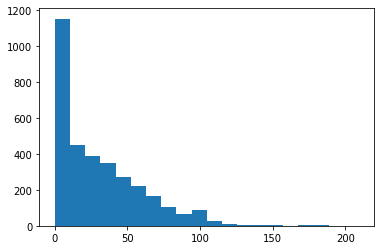

In [25]:
# count the nodes that are stopped
TOL = 1
node_ids = scenes_df['node_id'].unique()
max_dist = 0
min_dist = np.inf

count_stopped = 0
count_all = 0
dist_memo = np.zeros(node_ids.size)
for idx, node_id in enumerate(tqdm(node_ids)):
    count_all += 1
    node_df = scenes_df[scenes_df['node_id'] == node_id]
    pos0 = node_df.iloc[0][['position_x', 'position_y']].values.astype(float)
    posN = node_df.iloc[-1][['position_x', 'position_y']].values.astype(float)
    dist = np.linalg.norm(posN - pos0)
    dist_memo[idx] = dist
    if dist > max_dist:
        max_dist = dist
    if dist < min_dist:
        min_dist = dist
    if dist < TOL:
        # stopped vehicle
        count_stopped += 1

print(f"Min/max distances are {min_dist}, {max_dist} respectively.")
print("{} / {} or {:.2%} vehicles are stopped (within {}m between origin and destination).".format(
        count_stopped, count_all, count_stopped / count_all, TOL))
plt.hist(dist_memo, bins=20)
None

count is 0


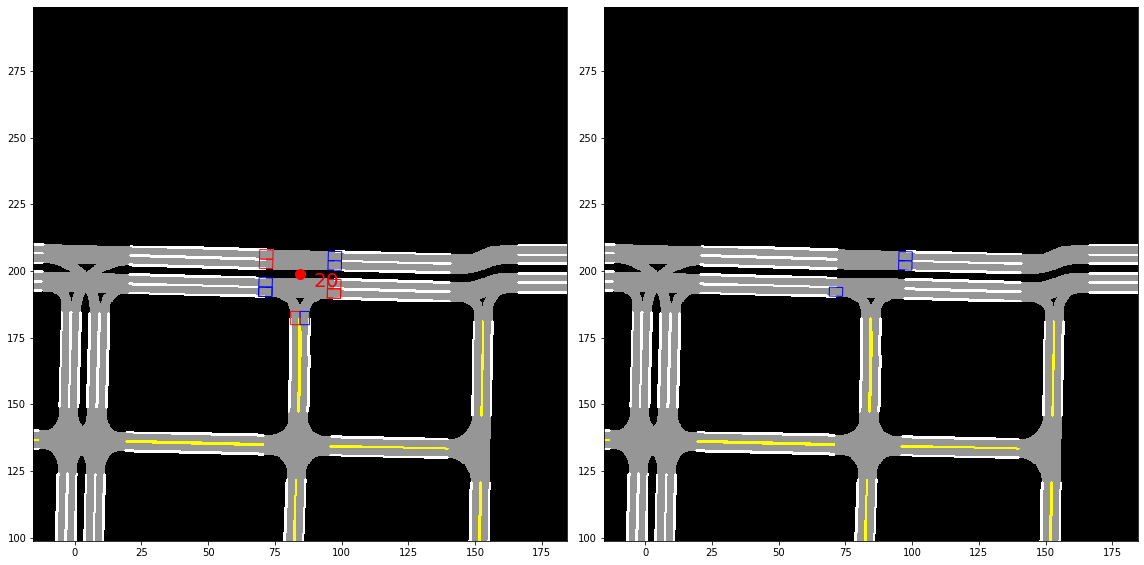

In [24]:
# plot the trajectories at an intersection

# waypoints to vertex set
f = lambda x, y, yaw, l: util.vertices_from_bbox(np.array([x, y]), yaw, np.array([5.0, 0.95*l]))
vertex_set = np.stack(util.starmap(lambda wp, _: f(*wp), _junction['waypoints']))
vertex_set = vertex_set[:3] # duplicates?
smpoly = vertex_set_to_smpoly(vertex_set)

fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes = axes.ravel()

# find junction and entrances/exits
ax = axes[0]
x, y = _junction['pos']
ax.plot(x, y, 'ro', markersize=10)
ax.text(x + 5, y - 5, str(sel_indices[_j_idx]), color='r', size=20)
for _wp1, _wp2 in _junction['waypoints']:
    # entrances
    x, y, yaw, lane_width = _wp1
    lw = np.array([5.0, lane_width])
    bbox = util.vertices_from_bbox(np.array([x, y]), yaw, lw)
    bb = patches.Polygon(bbox, closed=True, color='b', fc='none')
    ax.add_patch(bb)
    # exits
    x, y, yaw, lane_width = _wp2
    lw = np.array([5.0, lane_width])
    bbox = util.vertices_from_bbox(np.array([x, y]), yaw, lw)
    bb = patches.Polygon(bbox, closed=True, color='r', fc='none')
    ax.add_patch(bb)

# find routes that interset with vertices
ax = axes[1]
idx = 0
for node_id, _sls in node_id_to_pts.items():
    res = _sls.intersection(smpoly)
    if not res.is_empty:
        X = np.array(_sls.coords).T
        ax.plot(X[0], X[1], '-o', markersize=1, color=AGENT_COLORS[idx % NCOLORS])
        idx += 1
print("count is", idx)

plot_smpoly(ax, smpoly)

zoom_level = 100
for ax in axes:
    x_min, y_min = _junction['pos'] - zoom_level
    x_max, y_max = _junction['pos'] + zoom_level
    extent = (x_min, x_max, y_min, y_max)
    render_map(ax, extent)
    ax.set_aspect('equal')

fig.tight_layout()
None

vertex set has shape (14, 2, 4, 2)
151 vehicles are crossing the intersection.


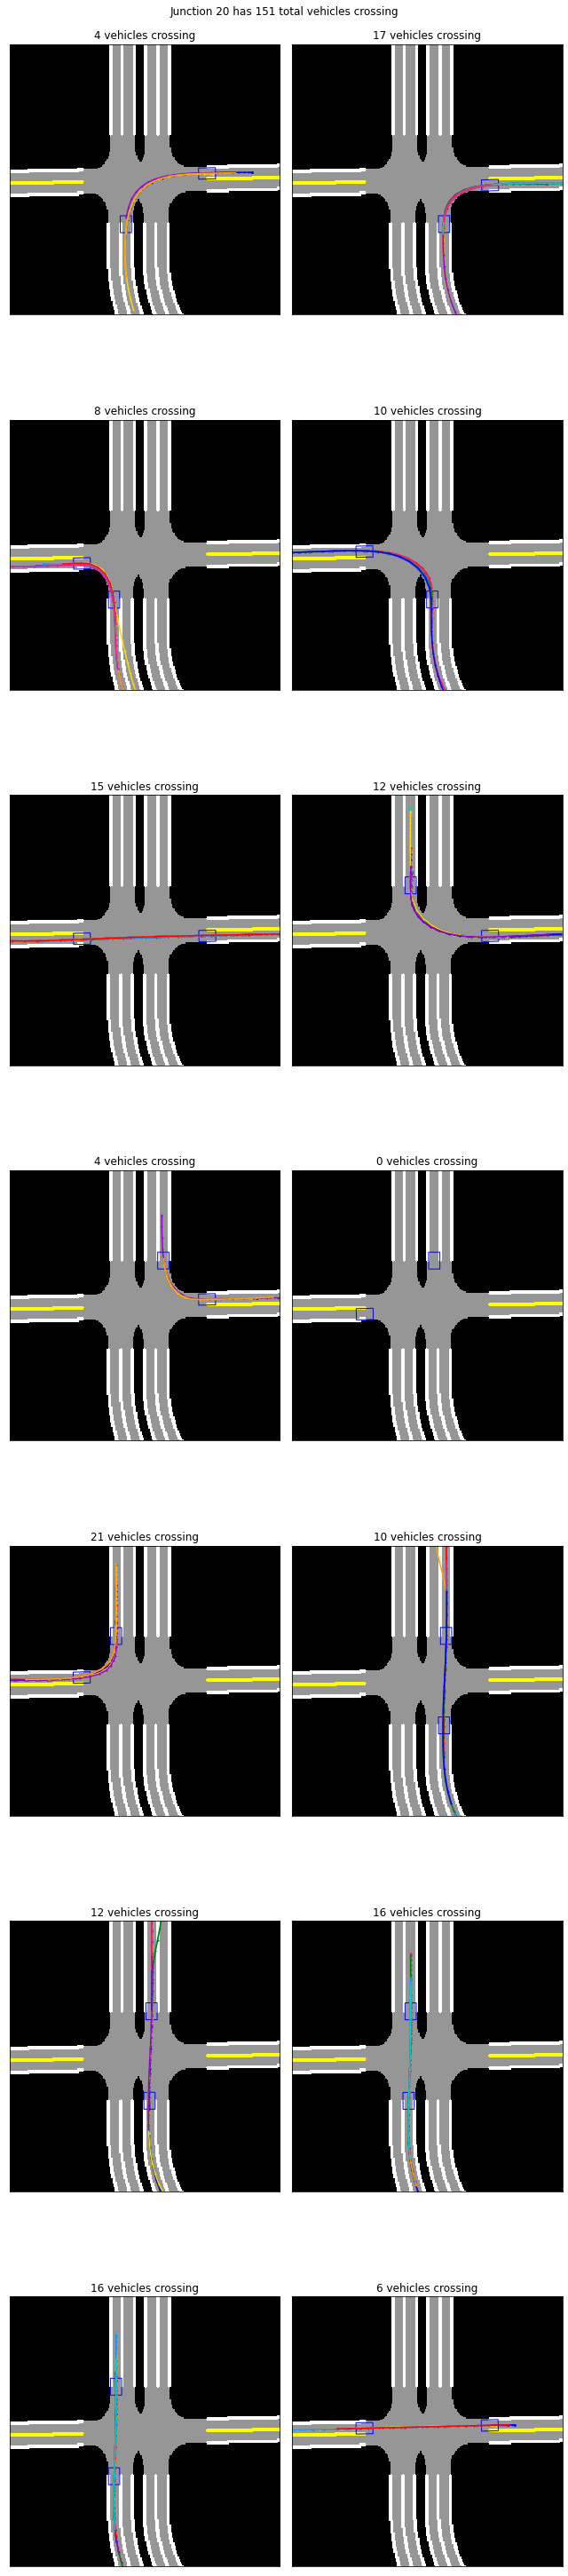

In [29]:
# plot at intersection

# waypoints to vertex set
f = lambda x, y, yaw, l: util.vertices_from_bbox(np.array([x, y]), yaw, np.array([5.0, 0.95*l]))
vertex_set = util.map_to_ndarray(lambda wps: util.starmap(f, wps), _junction['waypoints'])
print("vertex set has shape", vertex_set.shape)
smpolys = util.map_to_list(vertex_set_to_smpoly, vertex_set)

# TODO: prefiter vertices at intersection

count = 0
nodes_at_intersection = {}
for node_id, sls in node_id_to_pts.items():
    for idx, smpoly in enumerate(smpolys):
        spoly_enter = util.select(smpoly.geoms, 0)
        spoly_exit  = util.select(smpoly.geoms, 1)
        res = sls.intersection(spoly_enter)
        if not res.is_empty:
            res = sls.intersection(spoly_exit)
            if not res.is_empty:
                if idx in nodes_at_intersection:
                    nodes_at_intersection[idx].append((node_id, sls))
                else:
                    nodes_at_intersection[idx] = [(node_id, sls)]
                count += 1
print(f"{count} vehicles are crossing the intersection.")        

n_axes = len(smpolys)
fig, axes = plt.subplots(n_axes // 2 + n_axes % 2, 2, figsize=(9, 3*n_axes))
axes = axes.ravel()

zoom_level = 40
for idx, smpoly in enumerate(smpolys):
    x_min, y_min = _junction['pos'] - zoom_level
    x_max, y_max = _junction['pos'] + zoom_level
    extent = (x_min, x_max, y_min, y_max)
    render_map(axes[idx], extent)
    plot_smpoly(axes[idx], smpoly)
    v_idx = 0
    try:
        for node_id, sls in nodes_at_intersection[idx]:
            X = np.array(sls.coords).T
            axes[idx].plot(X[0], X[1], '-o', markersize=1, color=AGENT_COLORS[v_idx % NCOLORS])
            v_idx += 1
    except KeyError:
        pass
    axes[idx].set_aspect('equal')
    axes[idx].set_xlim(extent[:2])
    axes[idx].set_ylim(extent[2:])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
    axes[idx].set_title(f"{v_idx} vehicles crossing")

fig.suptitle(f"Junction {sel_indices[_j_idx]} has {count} total vehicles crossing")
fig.tight_layout()

Further inspection

There are 5355 nodes across the entire dataset.


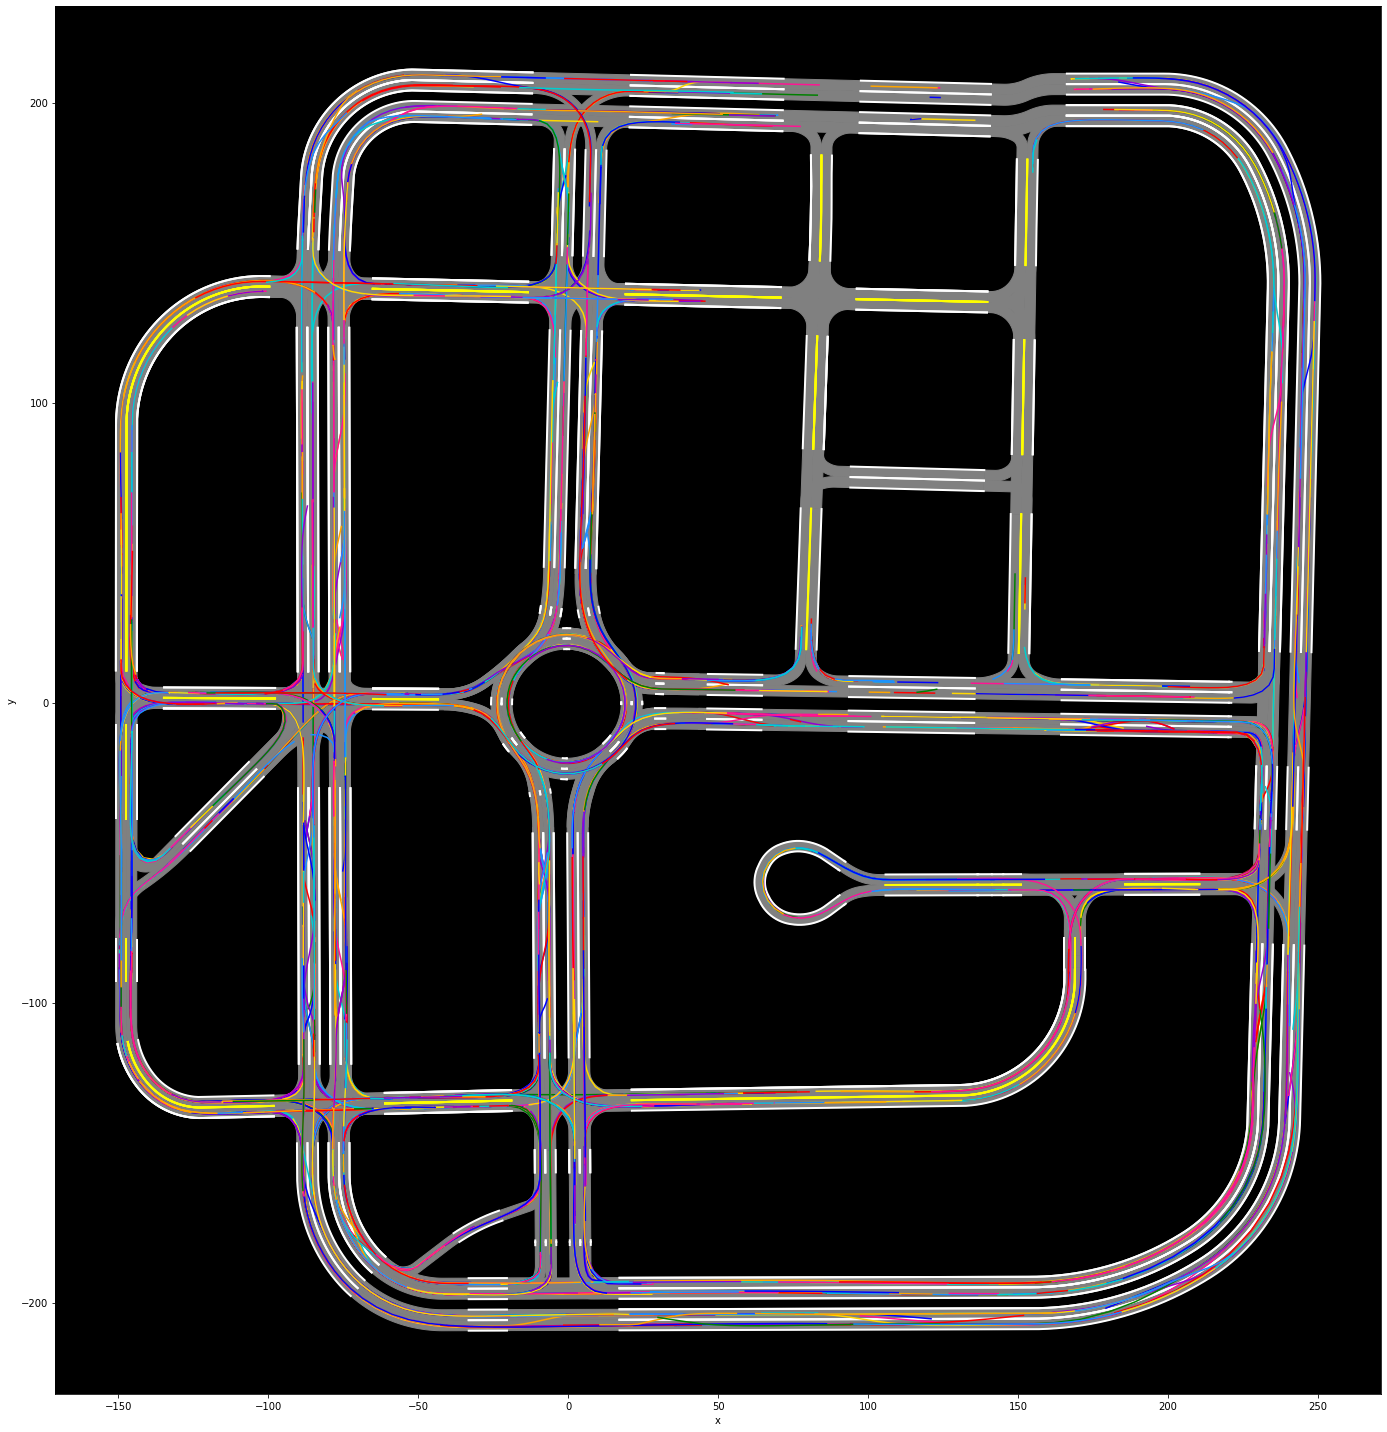

In [20]:
# Plot all trajectories over map.
scenes_df = scenes_to_df(eval_scenes)
scenes_df

fig, ax = plt.subplots(figsize=(20,20))
render_entire_map(ax)

node_ids = scenes_df['node_id'].unique()
print(f"There are {node_ids.size} nodes across the entire dataset.")
for idx, node_id in enumerate(node_ids):
    node_df = scenes_df[scenes_df['node_id'] == node_id]
    X = node_df[['position_x', 'position_y']].values.T
    ax.plot(X[0], X[1], '-', color=AGENT_COLORS[idx % NCOLORS])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_facecolor('black')
fig.tight_layout()

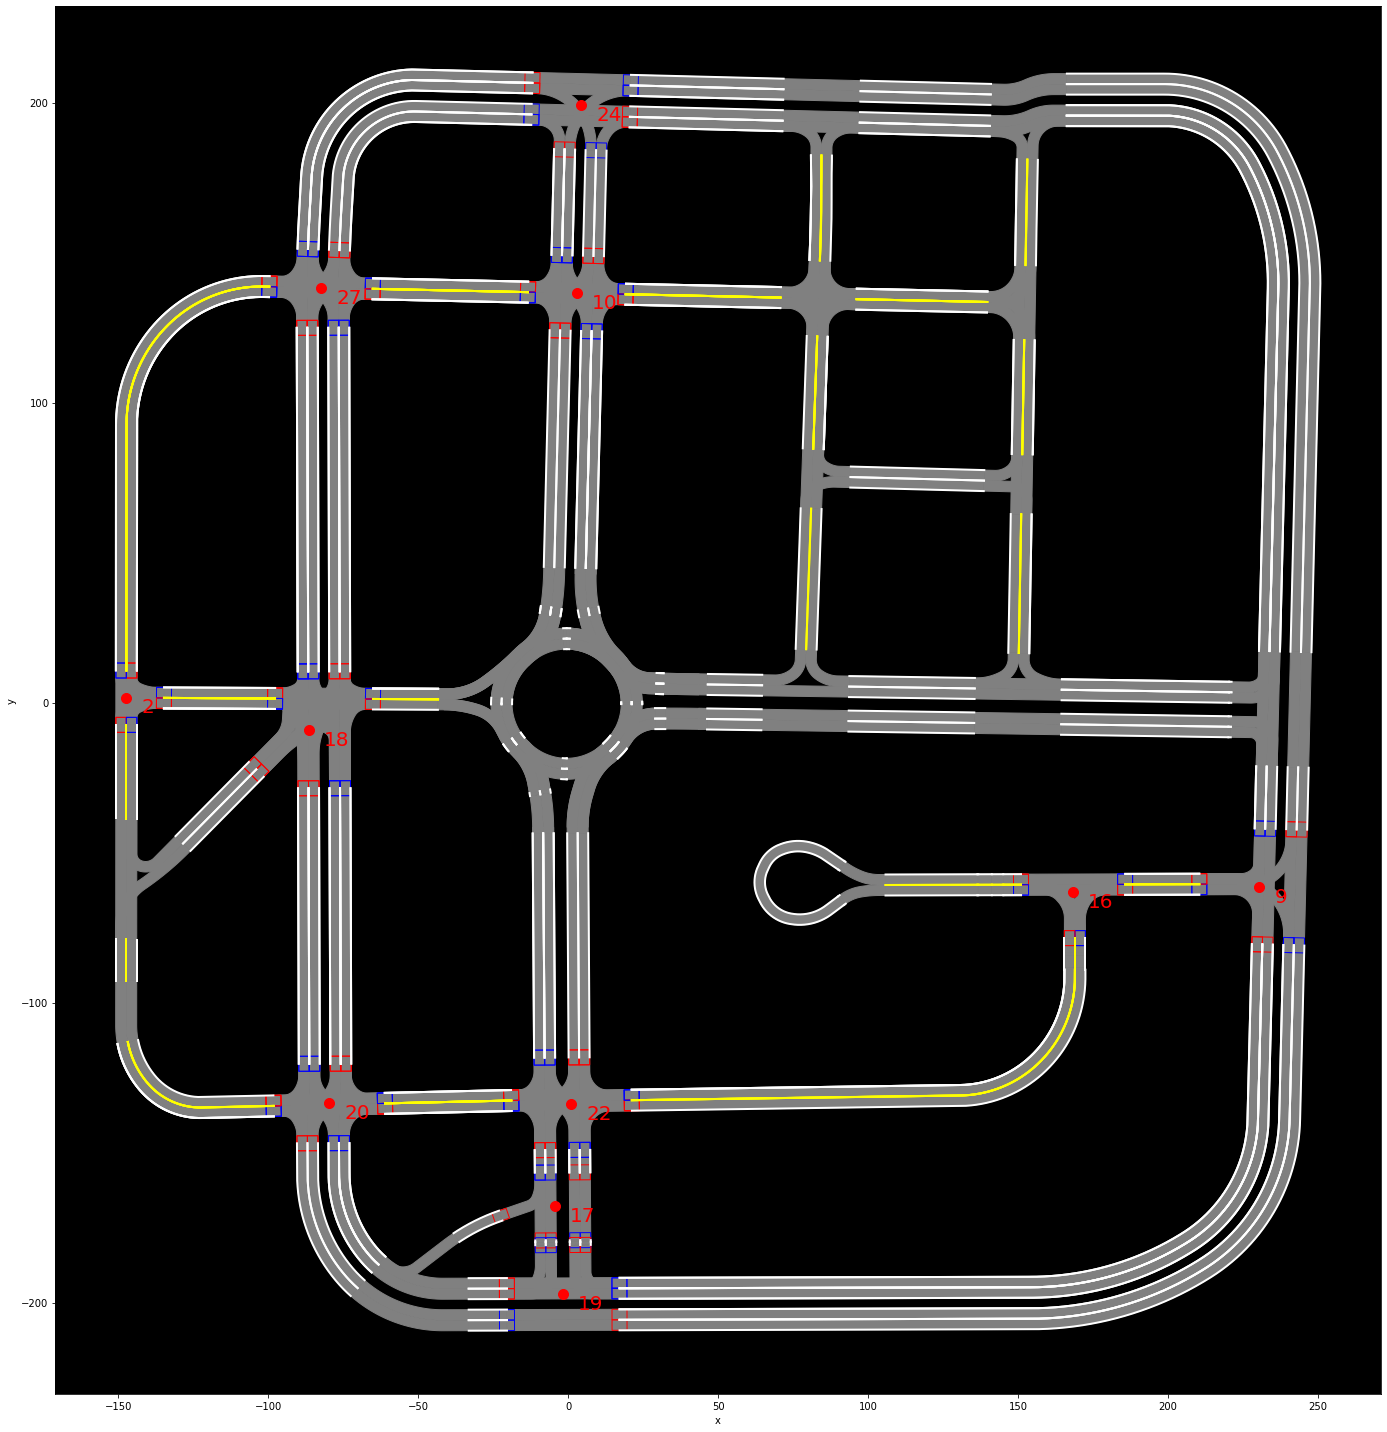

In [21]:
# Plot selected junctions entrances/exits
fig, ax = plt.subplots(figsize=(20,20))
render_entire_map(ax)

sel_indices = [2, 9, 16, 18, 20, 22, 24, 27, 10, 17, 19]
_junctions = util.select(junctions, sel_indices)
for idx, junction in enumerate(_junctions):
    x, y = junction['pos']
    ax.plot(x, y, 'ro', markersize=10)
    ax.text(x + 5, y - 5, str(sel_indices[idx]), color='r', size=20)
    for _wp1, _wp2 in junction['waypoints']:
        # entrances
        x, y, yaw, lane_width = _wp1
        lw = np.array([5.0, lane_width])
        bbox = util.vertices_from_bbox(np.array([x, y]), yaw, lw)
        bb = patches.Polygon(bbox, closed=True, color='b', fc='none')
        ax.add_patch(bb)
        # exits
        x, y, yaw, lane_width = _wp2
        lw = np.array([5.0, lane_width])
        bbox = util.vertices_from_bbox(np.array([x, y]), yaw, lw)
        bb = patches.Polygon(bbox, closed=True, color='r', fc='none')
        ax.add_patch(bb)
        
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_facecolor('black')
fig.tight_layout()